In [1]:
# ================================
# IMPORT LIBRARIES AND SETUP
# ================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from pathlib import Path
import seaborn as sns
import warnings
import os
import pickle
from pykalman import KalmanFilter
from math import radians, sin, cos, atan2, degrees
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.preprocessing import MinMaxScaler ,LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Set random seeds for reproducibility
np.random.seed(42)

# Create directories for artifacts and visualizations
artifacts_dir = Path('artifacts')
artifacts_dir.mkdir(exist_ok=True)
viz_dir = Path('visualization')
viz_dir.mkdir(exist_ok=True)

os.makedirs(artifacts_dir, exist_ok=True)

print("All libraries imported successfully!")
print(f"Artifacts will be saved in: {artifacts_dir}")
print(f"Visualizations will be saved in: {viz_dir}")

All libraries imported successfully!
Artifacts will be saved in: artifacts
Visualizations will be saved in: visualization


In [30]:
# =============================
# 2. DATA ACQUISITION
# ================================

# Load the TON_IoT door sensor dataset
# Note: Replace 'ton_iot_door_sensor.csv' with your actual file path
df = pd.read_csv(r'D:\Skripsi\Train_Test_datasets\Train_Test_IoT_dataset\Train_Test_IoT_GPS_Tracker.csv')
print("Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")

# Display basic information about the dataset
print("\n" + "="*50)
print("DATASET OVERVIEW")
print("="*50)
print(df.head(10))
print(f"\nDataset Info:")
print(df.info())
print(f"\nDataset Description:")
print(df.describe())

Dataset loaded successfully!
Dataset shape: (38960, 6)

DATASET OVERVIEW
        date        time    latitude   longitude  label  type
0  25-Apr-19   18:31:39   116.521704  132.162504      1  ddos
1  25-Apr-19   18:31:41   121.742933  135.072500      1  ddos
2  25-Apr-19   18:31:46   121.795929  135.110198      1  ddos
3  25-Apr-19   18:31:49   116.611216  132.224555      1  ddos
4  25-Apr-19   18:31:51   121.841526  135.151362      1  ddos
5  25-Apr-19   18:31:54   116.646869  132.295876      1  ddos
6  25-Apr-19   18:31:59   116.649518  132.419949      1  ddos
7  25-Apr-19   18:32:01   121.920022  135.308132      1  ddos
8  25-Apr-19   18:32:04   116.706300  132.420231      1  ddos
9  25-Apr-19   18:32:06   122.002085  135.325050      1  ddos

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38960 entries, 0 to 38959
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       38960 non-null  object 
 1

Data Types:
date          object
time          object
latitude     float64
longitude    float64
label          int64
type          object
dtype: object

Latitude stats:
count    38960.000000
mean        55.520048
std         75.345705
min          0.000000
25%          2.427997
50%         36.623451
75%         86.592301
max        549.381916
Name: latitude, dtype: float64

Longitude stats:
count    38960.000000
mean        65.849669
std         76.086241
min         10.000000
25%         12.459648
50%         47.244773
75%         96.119494
max        555.133643
Name: longitude, dtype: float64

Unique attack types: ['ddos' 'backdoor' 'injection' 'normal' 'password' 'ransomware' 'scanning'
 'xss']
Attack type distribution:
type
normal        15000
ddos           5000
backdoor       5000
injection      5000
password       5000
ransomware     2833
xss             577
scanning        550
Name: count, dtype: int64

Label distribution:
label
1    23960
0    15000
Name: count, dtype: int64


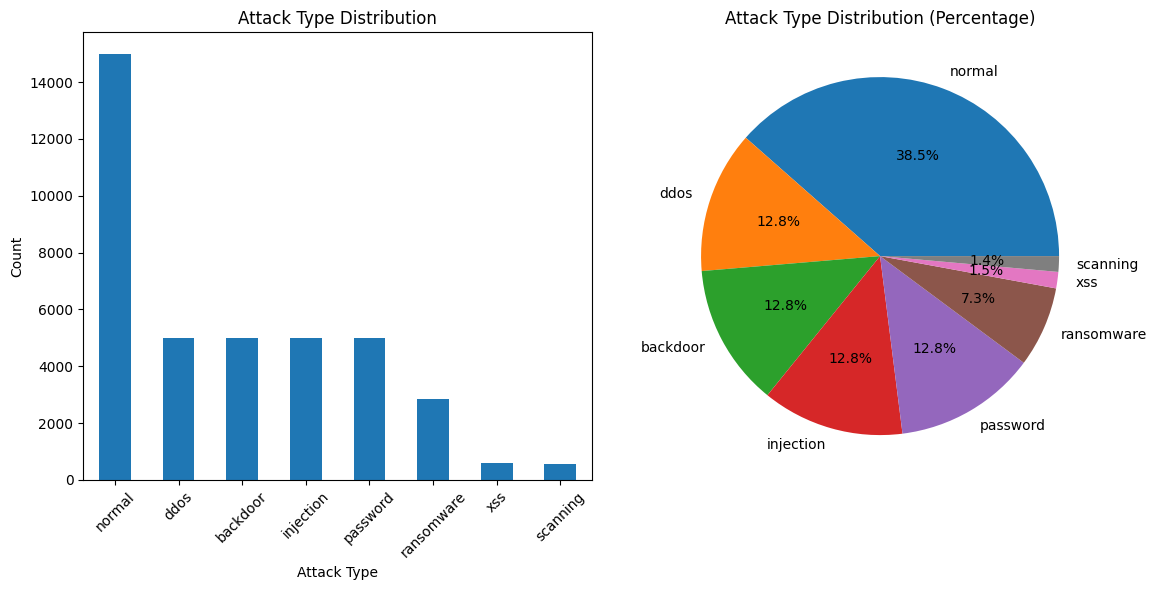

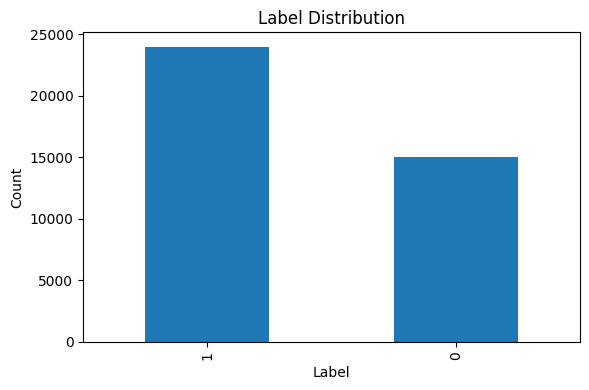

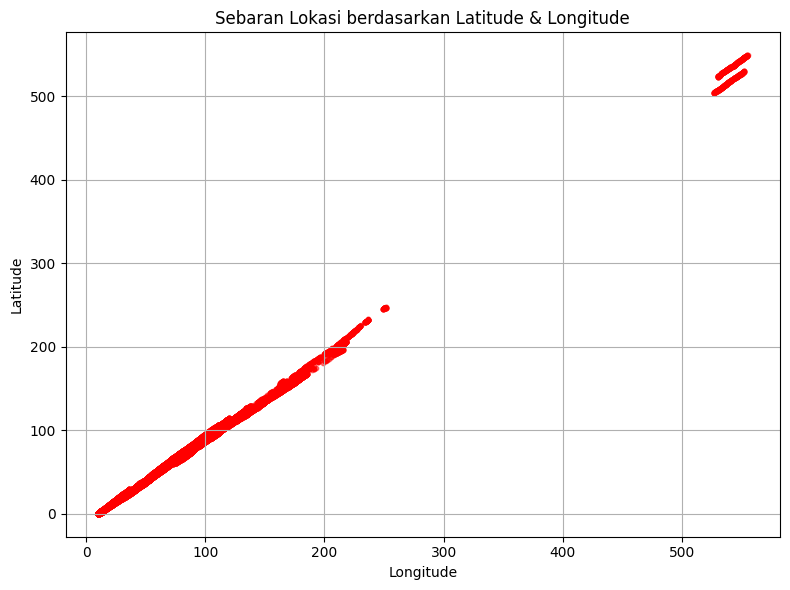

In [31]:
# Check data types
print("Data Types:")
print(df.dtypes)

print("\nLatitude stats:")
print(df['latitude'].describe())

print("\nLongitude stats:")
print(df['longitude'].describe())

# Check unique values in categorical columns
print(f"\nUnique attack types: {df['type'].unique()}")
print(f"Attack type distribution:")
attack_distribution = df['type'].value_counts()
print(attack_distribution)

print(f"\nLabel distribution:")
label_distribution = df['label'].value_counts()
print(label_distribution)

# Visualize attack type distribution
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
df['type'].value_counts().plot(kind='bar', rot=45)
plt.title('Attack Type Distribution')
plt.xlabel('Attack Type')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
df['type'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Attack Type Distribution (Percentage)')
plt.ylabel('')

plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'attack_type_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

# Visualize label distribution
plt.figure(figsize=(6,4))
df['label'].value_counts().plot(kind='bar')
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'label_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(df['longitude'], df['latitude'], 
            c='red', alpha=0.5, s=10)
plt.title('Sebaran Lokasi berdasarkan Latitude & Longitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'location_scatter.png'), dpi=300, bbox_inches='tight')
plt.show()

In [32]:
# Implementasi Kalman Filter untuk sphone_signal
def apply_kalman_filter(signal_data):
    if hasattr(signal_data, 'values'):
        signal_array = signal_data.values
    else:
        signal_array = np.array(signal_data)
    observations = signal_array.reshape(-1, 1)
    kf = KalmanFilter(
        transition_matrices=np.array([[1, 1], [0, 1]]),
        observation_matrices=np.array([[1, 0]]),
        initial_state_mean=np.array([signal_array[0], 0]),
        initial_state_covariance=np.eye(2),
        observation_covariance=np.array([[1.0]]),
        transition_covariance=np.array([[0.1, 0], [0, 0.1]]),
        n_dim_state=2
    )
    kf_fitted = kf.em(observations, n_iter=10)
    state_means, _ = kf_fitted.smooth(observations)
    return state_means[:, 0]

In [33]:
df_filtered = df.copy()
df_filtered['latitude'] = apply_kalman_filter(df['latitude'])
df_filtered['longitude'] = apply_kalman_filter(df['longitude'])

In [34]:
# ================================
# FEATURE ENGINEERING
# ================================

print("\n" + "="*50)
print("FEATURE ENGINEERING")
print("="*50)

# Fungsi perhitungan jarak Haversine
def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # Radius bumi dalam meter
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(a**0.5, (1-a)**0.5)
    return R * c

# Fungsi perhitungan bearing
def calculate_bearing(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    x = cos(lat2) * sin(dlon)
    y = cos(lat1) * sin(lat2) - sin(lat1) * cos(lat2) * cos(dlon)
    bearing = atan2(x, y)
    bearing = degrees(bearing)
    return (bearing + 360) % 360

# Fungsi normalisasi sudut untuk direction change
def normalize_angle(diff):
    return (diff + 180) % 360 - 180

# Create a copy for preprocessing
df_processed = df_filtered.copy()

# Gabungkan kolom date dan time menjadi satu kolom
df_processed['datetime'] = pd.to_datetime(
    (df_processed['date'] + ' ' + df_processed['time']).str.strip(),
    format='%d-%b-%y %H:%M:%S',
    errors='coerce'
)

# Extract time-based features
df_processed['hour'] = df_processed['datetime'].dt.hour
df_processed['minute'] = df_processed['datetime'].dt.minute
df_processed['second'] = df_processed['datetime'].dt.second
df_processed['day_of_week'] = df_processed['datetime'].dt.dayofweek
df_processed['is_weekend'] = (df_processed['day_of_week'] >= 5).astype(int)

# Create time-based cyclical features
df_processed['hour_sin'] = np.sin(2 * np.pi * df_processed['hour'] / 24)
df_processed['hour_cos'] = np.cos(2 * np.pi * df_processed['hour'] / 24)
df_processed['minute_sin'] = np.sin(2 * np.pi * df_processed['minute'] / 60)
df_processed['minute_cos'] = np.cos(2 * np.pi * df_processed['minute'] / 60)
df_processed['second_sin'] = np.cos(2 * np.pi * df_processed['second'] / 60)
df_processed['second_cos'] = np.cos(2 * np.pi * df_processed['second'] / 60)

df_processed['is_business_hour'] = ((df_processed['hour'] >= 9) & (df_processed['hour'] <= 17)).astype(int)
df_processed['is_night'] = ((df_processed['hour'] >= 22) | (df_processed['hour'] <= 6)).astype(int)
df_processed['is_rush_hour'] = (((df_processed['hour'] >= 7) & (df_processed['hour'] <= 9)) | 
                     ((df_processed['hour'] >= 17) & (df_processed['hour'] <= 19))).astype(int)

# 3. Fitur Geospatial
## Perubahan longitude
df_processed['delta_lon'] = df_processed['longitude'].diff()

## Bearing dan direction change
df_processed['prev_lat'] = df_processed['latitude'].shift(1)
df_processed['prev_lon'] = df_processed['longitude'].shift(1)

# Hitung bearing
df_processed['bearing'] = df_processed.apply(
    lambda row: calculate_bearing(
        row['prev_lat'], row['prev_lon'],
        row['latitude'], row['longitude']
    ) if not pd.isna(row['prev_lat']) else np.nan,
    axis=1
)

# Encoding bearing
df_processed['bearing_sin'] = np.sin(np.radians(df_processed['bearing']))
df_processed['bearing_cos'] = np.cos(np.radians(df_processed['bearing']))

# Hitung direction change
df_processed['prev_bearing'] = df_processed['bearing'].shift(1)
df_processed['bearing_diff'] = df_processed['bearing'] - df_processed['prev_bearing']
df_processed['normalized_diff'] = df_processed['bearing_diff'].apply(
    lambda x: normalize_angle(x) if not pd.isna(x) else np.nan
)
df_processed['direction_change'] = np.abs(df_processed['normalized_diff'])

# 4. Fitur Pergerakan
## Hitung selisih waktu
df_processed['time_diff'] = df_processed['datetime'].diff().dt.total_seconds()

## Hitung jarak Haversine
df_processed['distance_m_haversine'] = df_processed.apply(
    lambda row: haversine(
        row['prev_lat'], row['prev_lon'],
        row['latitude'], row['longitude']
    ) if not pd.isna(row['prev_lat']) else 0,
    axis=1
)

## Hitung kecepatan (m/s)
df_processed['speed_m_s'] = df_processed['distance_m_haversine'] / df_processed['time_diff']
df_processed['speed_m_s'] = df_processed['speed_m_s'].replace([np.inf, -np.inf], np.nan).fillna(0)

## Hitung percepatan
df_processed['prev_speed'] = df_processed['speed_m_s'].shift(1)
df_processed['acceleration'] = (df_processed['speed_m_s'] - df_processed['prev_speed']) / df_processed['time_diff']
df_processed['acceleration'] = df_processed['acceleration'].replace([np.inf, -np.inf], np.nan).fillna(0)

## Hitung jerk (turunan percepatan)
df_processed['prev_accel'] = df_processed['acceleration'].shift(1)
df_processed['jerk'] = (df_processed['acceleration'] - df_processed['prev_accel']) / df_processed['time_diff']
df_processed['jerk'] = df_processed['jerk'].replace([np.inf, -np.inf], np.nan).fillna(0)

# 5. Fitur Sekuensial
## Rolling features (window=5)
df_processed['speed_rolling_mean_5'] = df_processed['speed_m_s'].rolling(window=5, min_periods=1).mean()
df_processed['speed_rolling_std_5'] = df_processed['speed_m_s'].rolling(window=5, min_periods=1).std().fillna(0)
df_processed['distance_rolling_mean_5'] = df_processed['distance_m_haversine'].rolling(window=5, min_periods=1).mean()

## Lag features
df_processed['speed_lag_1'] = df_processed['speed_m_s'].shift(1).fillna(0)
df_processed['speed_lag_2'] = df_processed['speed_m_s'].shift(2).fillna(0)

## Jarak kumulatif
df_processed['cumulative_distance'] = df_processed['distance_m_haversine'].cumsum()

# 6. Fitur Perilaku
## Z-score
for col in ['speed_m_s', 'distance_m_haversine', 'time_diff']:
    mean_val = df_processed[col].mean()
    std_val = df_processed[col].std()
    df_processed[f'{col}_zscore'] = (df_processed[col] - mean_val) / std_val if std_val != 0 else 0

## Deteksi anomali
df_processed['is_speed_anomaly'] = (np.abs(df_processed['speed_m_s_zscore']) > 3).astype(int)
df_processed['is_distance_anomaly'] = (np.abs(df_processed['distance_m_haversine_zscore']) > 3).astype(int)
df_processed['is_time_anomaly'] = (np.abs(df_processed['time_diff_zscore']) > 3).astype(int)

## Encode pola pergerakan
speed_bins = [-np.inf, 0.1, 1.0, 5.0, np.inf]
df_processed['movement_pattern_encoded'] = pd.cut(
    df_processed['speed_m_s'], 
    bins=speed_bins, 
    labels=[0, 1, 2, 3]
).cat.codes

# 7. Membersihkan kolom sementara
cols_to_drop = [
    'date', 'time', 'prev_lat', 'prev_lon', 'prev_bearing',
    'bearing_diff', 'normalized_diff', 'prev_speed', 'prev_accel',
    'hour', 'minute', 'second', 'day_of_week'
]
df_processed.drop(columns=cols_to_drop, inplace=True, errors='ignore')

print("Feature engineering completed!")
print(df.head())
print("\nKolom yang dihasilkan:", df_processed.columns.tolist())
print(df_processed.head())


FEATURE ENGINEERING
Feature engineering completed!
        date        time    latitude   longitude  label  type
0  25-Apr-19   18:31:39   116.521704  132.162504      1  ddos
1  25-Apr-19   18:31:41   121.742933  135.072500      1  ddos
2  25-Apr-19   18:31:46   121.795929  135.110198      1  ddos
3  25-Apr-19   18:31:49   116.611216  132.224555      1  ddos
4  25-Apr-19   18:31:51   121.841526  135.151362      1  ddos

Kolom yang dihasilkan: ['latitude', 'longitude', 'label', 'type', 'datetime', 'is_weekend', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'second_sin', 'second_cos', 'is_business_hour', 'is_night', 'is_rush_hour', 'delta_lon', 'bearing', 'bearing_sin', 'bearing_cos', 'direction_change', 'time_diff', 'distance_m_haversine', 'speed_m_s', 'acceleration', 'jerk', 'speed_rolling_mean_5', 'speed_rolling_std_5', 'distance_rolling_mean_5', 'speed_lag_1', 'speed_lag_2', 'cumulative_distance', 'speed_m_s_zscore', 'distance_m_haversine_zscore', 'time_diff_zscore', 'is_speed

In [35]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38960 entries, 0 to 38959
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   latitude                     38960 non-null  float64       
 1   longitude                    38960 non-null  float64       
 2   label                        38960 non-null  int64         
 3   type                         38960 non-null  object        
 4   datetime                     38960 non-null  datetime64[ns]
 5   is_weekend                   38960 non-null  int32         
 6   hour_sin                     38960 non-null  float64       
 7   hour_cos                     38960 non-null  float64       
 8   minute_sin                   38960 non-null  float64       
 9   minute_cos                   38960 non-null  float64       
 10  second_sin                   38960 non-null  float64       
 11  second_cos                   38960 non-nu


MISSING VALUES ANALYSIS
Missing values summary:
                  Missing Count  Missing Percentage
delta_lon                     1            0.002567
bearing                       1            0.002567
bearing_sin                   1            0.002567
bearing_cos                   1            0.002567
direction_change              2            0.005133
time_diff                     1            0.002567
time_diff_zscore              1            0.002567


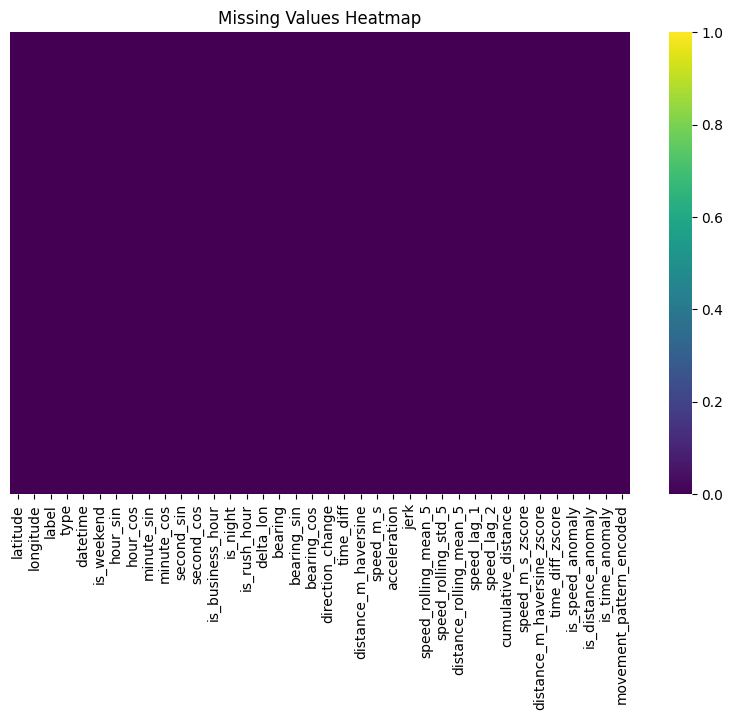

In [36]:
# ================================
# 5. IDENTIFYING MISSING VALUES
# ================================

print("\n" + "="*50)
print("MISSING VALUES ANALYSIS")
print("="*50)

# Check for missing values
missing_values = df_processed.isnull().sum()
missing_percentage = (missing_values / len(df_processed)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_percentage
})

print("Missing values summary:")
print(missing_df[missing_df['Missing Count'] > 0])

# Visualize missing values if any
if missing_values.sum() > 0:
    plt.figure(figsize=(10, 6))
    sns.heatmap(df_processed.isnull(), cbar=True, yticklabels=False, cmap='viridis')
    plt.title('Missing Values Heatmap')
    plt.savefig(os.path.join(viz_dir, 'missing_values_heatmap.png'), dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No missing values found in the dataset!")

In [37]:
print(df_processed.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38960 entries, 0 to 38959
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   latitude                     38960 non-null  float64       
 1   longitude                    38960 non-null  float64       
 2   label                        38960 non-null  int64         
 3   type                         38960 non-null  object        
 4   datetime                     38960 non-null  datetime64[ns]
 5   is_weekend                   38960 non-null  int32         
 6   hour_sin                     38960 non-null  float64       
 7   hour_cos                     38960 non-null  float64       
 8   minute_sin                   38960 non-null  float64       
 9   minute_cos                   38960 non-null  float64       
 10  second_sin                   38960 non-null  float64       
 11  second_cos                   38960 non-nu

In [38]:
# ================================
# 6. SIMPLE IMPUTER AND MINMAX SCALER
# ================================

print("\n" + "="*50)
print("DATA PREPROCESSING - IMPUTATION AND SCALING")
print("="*50)

# Select features for modeling
feature_columns = [
    # Temporal features (cyclical encoded)
    'hour_sin', 'hour_cos',
    'minute_sin', 'minute_cos', 
    'is_weekend', 'is_business_hour', 'is_night',
    
    # Geospatial features
    'longitude',
    'bearing_sin', 'bearing_cos', 'direction_change',
    
    # Movement features
    'acceleration',
    
    # Sequence features
    'speed_rolling_mean_5', 'speed_rolling_std_5',
    'distance_rolling_mean_5',
    'speed_lag_1', 'speed_lag_2',
    'cumulative_distance',
    
    # Behavioral features
    'speed_m_s_zscore', 'distance_m_haversine_zscore', 'time_diff_zscore',
    'is_speed_anomaly', 'is_distance_anomaly', 'is_time_anomaly',
    'movement_pattern_encoded'
]

# Prepare features and target
X = df_processed[feature_columns].copy()
y = df_processed['type'].copy()


# Handle any remaining missing values with SimpleImputer
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

print(f"Features shape after imputation: {X_imputed.shape}")

# Apply MinMax Scaling
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X_imputed.columns)

print("Data scaling completed!")
print(f"Scaled features shape: {X_scaled.shape}")

# Save preprocessors
with open(os.path.join(artifacts_dir, 'imputer.pkl'), 'wb') as f:
    pickle.dump(imputer, f)

with open(os.path.join(artifacts_dir, 'minmax.pkl'), 'wb') as f:
    pickle.dump(scaler, f)

print(f"Imputer saved to {artifacts_dir}/imputer.pkl")
print(f"Scaler saved to {artifacts_dir}/minmax.pkl")

# Encode target labels
label_encoder_target = LabelEncoder()
y_encoded = label_encoder_target.fit_transform(y)

# Save target label encoder
with open(os.path.join(artifacts_dir, 'label_encoder_target.pkl'), 'wb') as f:
    pickle.dump(label_encoder_target, f)

print(f"Target classes: {label_encoder_target.classes_}")
print(f"Target shape: {y_encoded.shape}")
print(f"Target label encoder saved to {artifacts_dir}/label_encoder_target.pkl")


DATA PREPROCESSING - IMPUTATION AND SCALING
Features shape after imputation: (38960, 25)
Data scaling completed!
Scaled features shape: (38960, 25)
Imputer saved to artifacts/imputer.pkl
Scaler saved to artifacts/minmax.pkl
Target classes: ['backdoor' 'ddos' 'injection' 'normal' 'password' 'ransomware' 'scanning'
 'xss']
Target shape: (38960,)
Target label encoder saved to artifacts/label_encoder_target.pkl


In [39]:
print(X_scaled.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38960 entries, 0 to 38959
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   hour_sin                     38960 non-null  float64
 1   hour_cos                     38960 non-null  float64
 2   minute_sin                   38960 non-null  float64
 3   minute_cos                   38960 non-null  float64
 4   is_weekend                   38960 non-null  float64
 5   is_business_hour             38960 non-null  float64
 6   is_night                     38960 non-null  float64
 7   longitude                    38960 non-null  float64
 8   bearing_sin                  38960 non-null  float64
 9   bearing_cos                  38960 non-null  float64
 10  direction_change             38960 non-null  float64
 11  acceleration                 38960 non-null  float64
 12  speed_rolling_mean_5         38960 non-null  float64
 13  speed_rolling_st


CORRELATION ANALYSIS


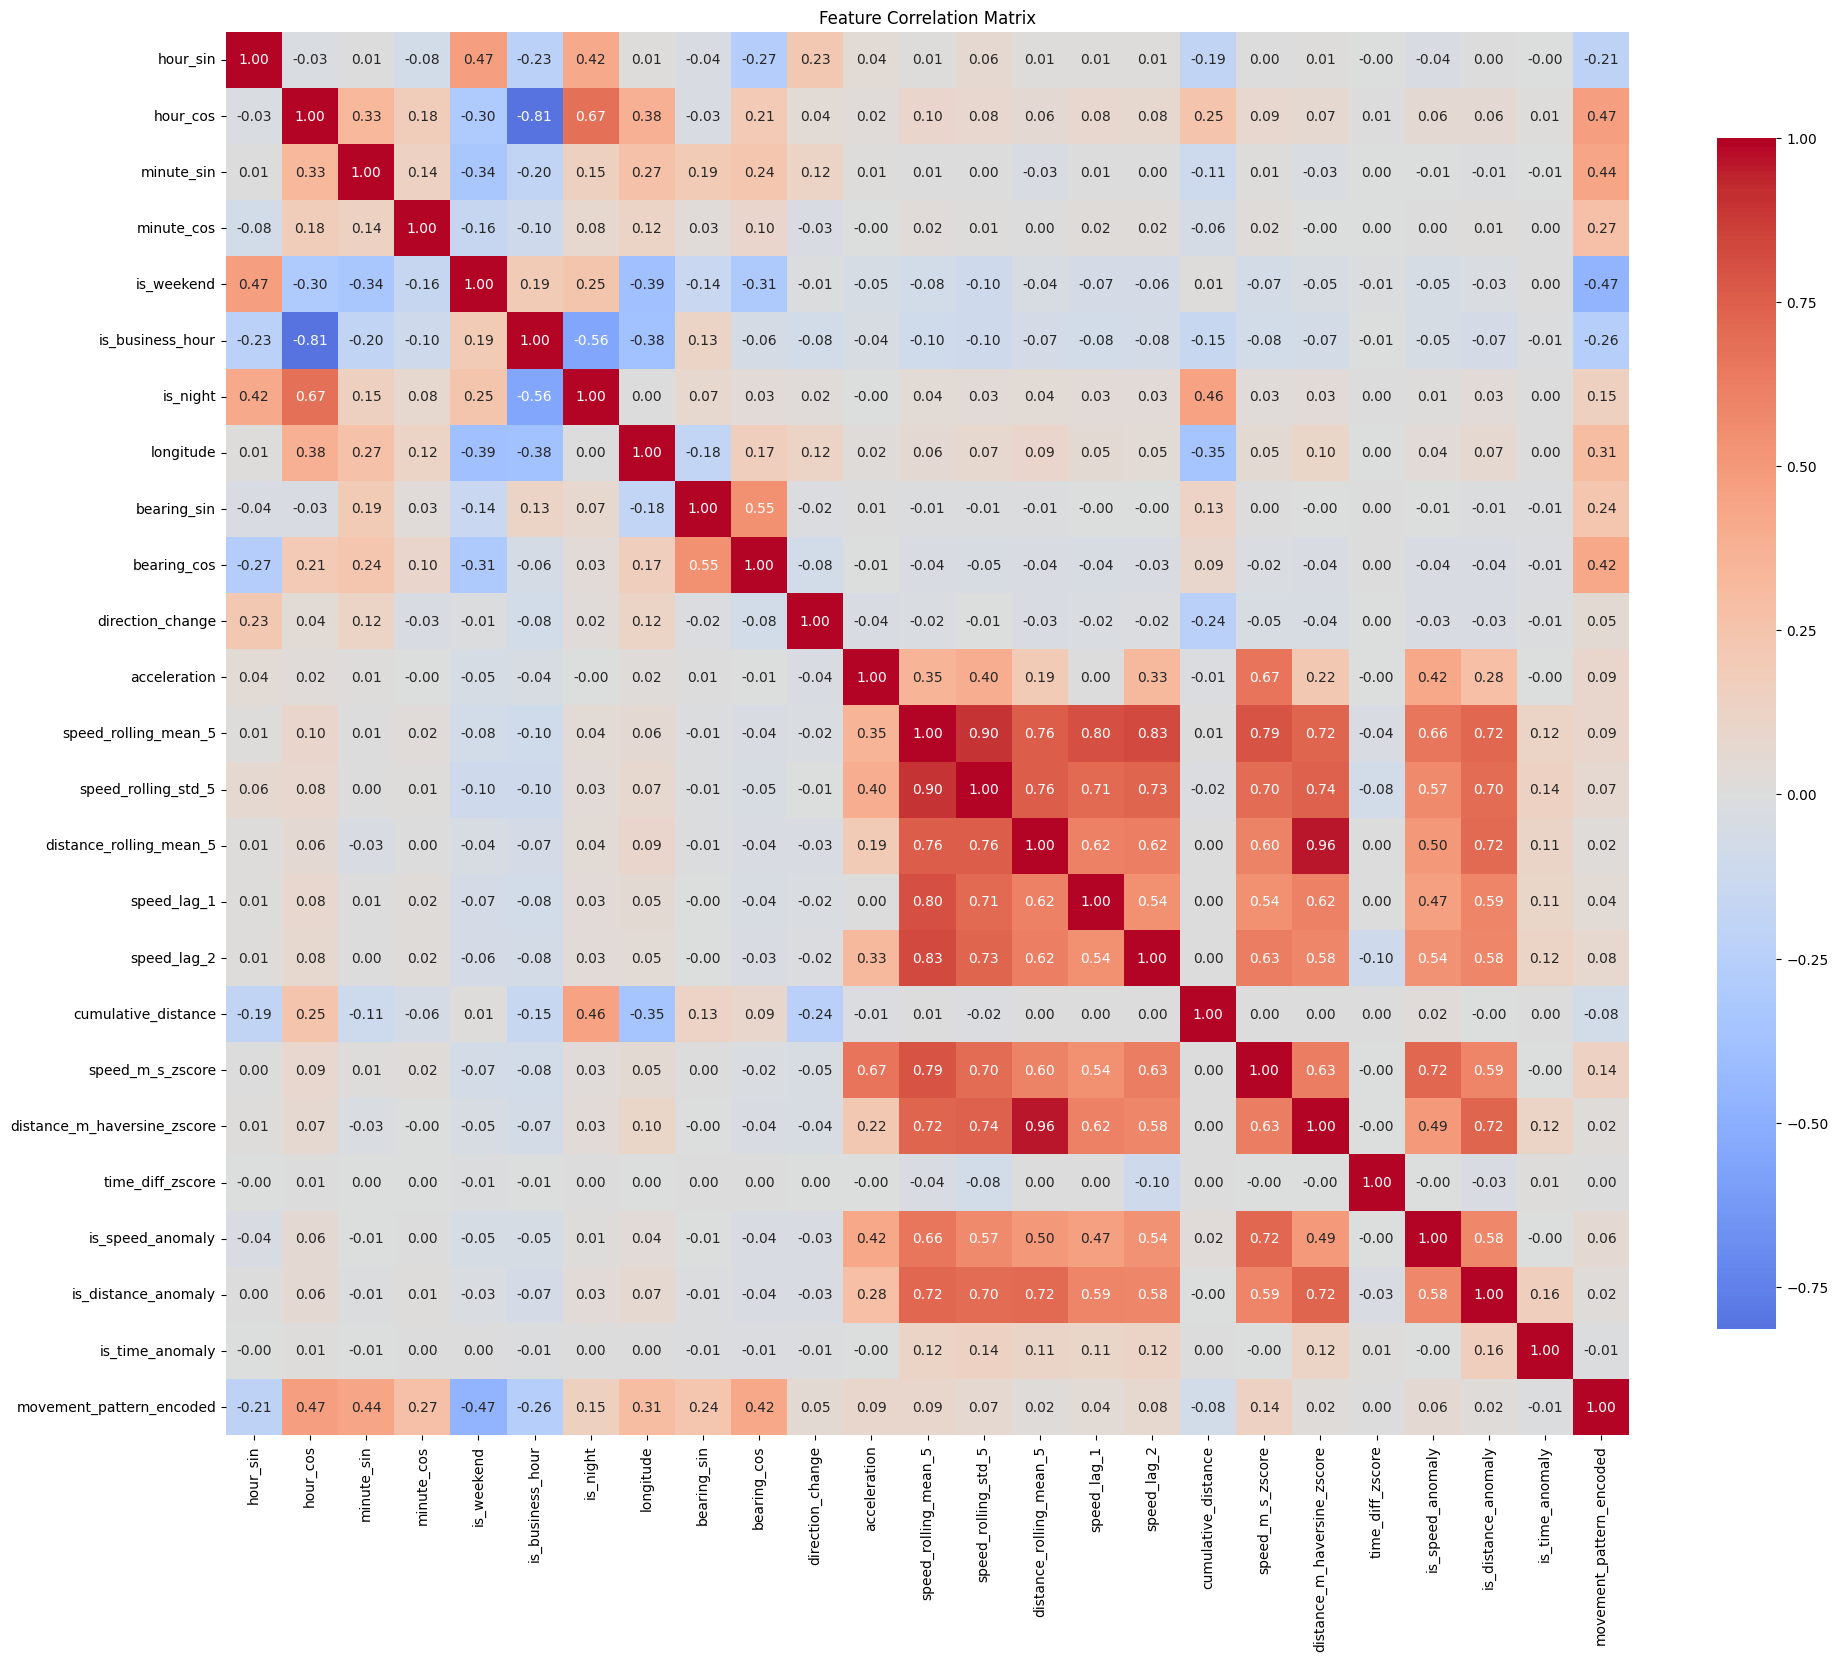

In [40]:
# ================================
# 7. CORRELATION ANALYSIS
# ================================

print("\n" + "="*50)
print("CORRELATION ANALYSIS")
print("="*50)

# Calculate correlation matrix
correlation_matrix = X_scaled.corr()

# Visualize correlation matrix
plt.figure(figsize=(20, 17))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'correlation_matrix.png'), dpi=600, bbox_inches='tight')
plt.show()
plt.close()

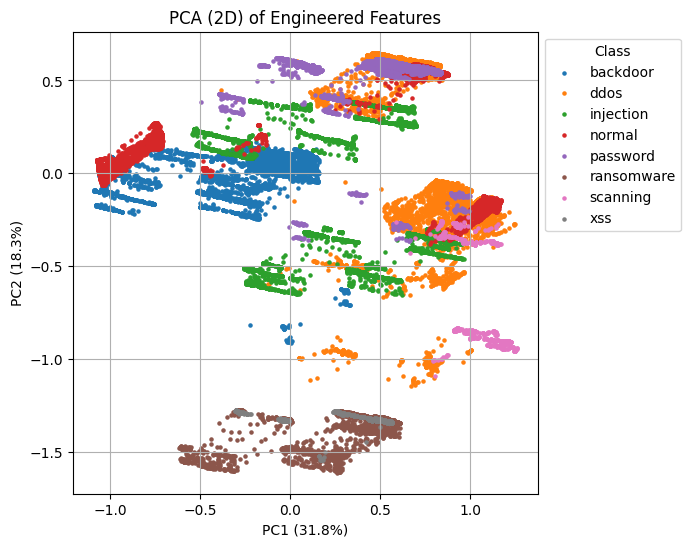

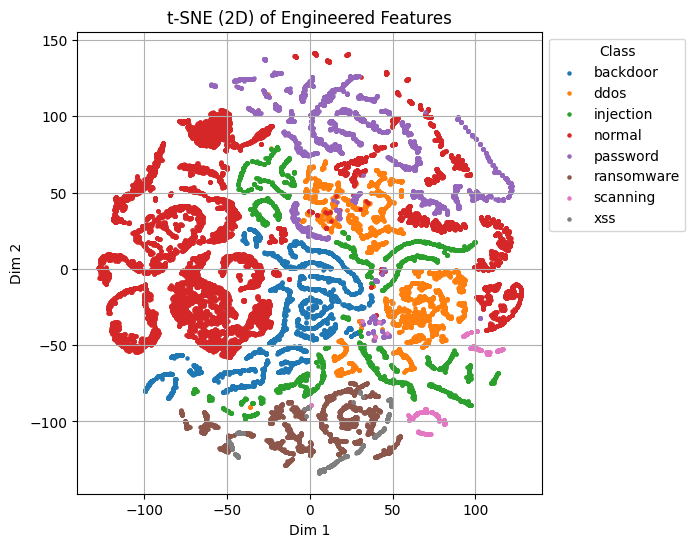

In [41]:
# PCA 2 Dimensi
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6,6))
for cls in np.unique(y):
    idx = y == cls
    plt.scatter(X_pca[idx,0], X_pca[idx,1], s=5, label=str(cls))
plt.legend(title='Class', bbox_to_anchor=(1,1))
plt.title('PCA (2D) of Engineered Features')
plt.xlabel('PC1 (%.1f%%)' % (pca.explained_variance_ratio_[0]*100))
plt.ylabel('PC2 (%.1f%%)' % (pca.explained_variance_ratio_[1]*100))
plt.grid(True)
plt.savefig(os.path.join(viz_dir, 'PCA_engineering_feature.png'), dpi=300, bbox_inches='tight')
plt.show()

# t-SNE → 2 dimensi (lebih lambat)
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)  # pada seluruh dataset atau subset

plt.figure(figsize=(6,6))
for cls in np.unique(y):
    idx = y == cls
    plt.scatter(X_tsne[idx,0], X_tsne[idx,1], s=5, label=str(cls))
plt.legend(title='Class', bbox_to_anchor=(1,1))
plt.title('t-SNE (2D) of Engineered Features')
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.grid(True)
plt.savefig(os.path.join(viz_dir, 'tSNE_2D_engineering_feature.png'), dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
tsne_3d = TSNE(n_components=3, perplexity=30, n_iter=1000, random_state=42)
X_tsne_3d = tsne_3d.fit_transform(X_scaled)

# Buat DataFrame untuk Plotly
df_tsne = pd.DataFrame({
    'Dim1': X_tsne_3d[:, 0],
    'Dim2': X_tsne_3d[:, 1],
    'Dim3': X_tsne_3d[:, 2],
    'Class': y.astype(str)
})

# Plot interaktif 3D
fig = px.scatter_3d(
    df_tsne,
    x='Dim1', y='Dim2', z='Dim3',
    color='Class',
    opacity=0.7,
    title='t-SNE (3D) of Engineered Features',
    width=900, height=700
)
fig.update_traces(marker=dict(size=4))
fig.update_layout(
    scene = dict(
        xaxis_title='Dim 1',
        yaxis_title='Dim 2',
        zaxis_title='Dim 3'
    ),
    legend_title='Class'
)

# Simpan file HTML ke folder viz_dir
html_path = os.path.join(viz_dir, 'tsne_3d.html')
fig.write_html(html_path)

print(f"File HTML disimpan di: {html_path}")

# PCA ke dalam 3 dimensi
pca = PCA(n_components=3, random_state=42)
X_pca_3d = pca.fit_transform(X_scaled)

# Buat DataFrame dari hasil PCA dan label
df_pca = pd.DataFrame(X_pca_3d, columns=['PC1', 'PC2', 'PC3'])
df_pca['label'] = y

# Visualisasi interaktif 3D menggunakan Plotly
fig = px.scatter_3d(
    df_pca, x='PC1', y='PC2', z='PC3',
    color='label',
    title='PCA (3D) of Engineered Features',
    labels={'label': 'Class'},
    opacity=0.7,
    width=800,
    height=600
)

# Simpan hasil visualisasi ke file HTML
output_html_path = os.path.join(viz_dir, 'PCA_3D.html')
fig.write_html(output_html_path)

File HTML disimpan di: visualization\tsne_3d.html


In [44]:
with open(os.path.join(artifacts_dir, 'data_preprocessing.pkl'), 'wb') as f:
    pickle.dump((X_scaled, y_encoded), f)